## DeepExplain - Inception V3 for natural image classification
### Comparison of classic and adversarially trained models for Tensorflow-Slim Inception V3

In [ ]:
%%bash
# Download TF checkpoints in data/models folder

wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
tar -xvzf inception_v3_2016_08_28.tar.gz -C data/models
rm inception_v3_2016_08_28.tar.gz

wget http://download.tensorflow.org/models/adv_inception_v3_2017_08_18.tar.gz
tar -xvzf adv_inception_v3_2017_08_18.tar.gz -C data/models
rm adv_inception_v3_2017_08_18.tar.gz

In [58]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
from scipy.misc import imread
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception

slim = tf.contrib.slim
    
from deepexplain.tensorflow import DeepExplain

In [59]:
# Define aux function to import images in batches
def load_images(batch_shape):
    images = np.zeros(batch_shape)
    filenames = []
    idx = 0
    batch_size = batch_shape[0]
    for filepath in tf.gfile.Glob(os.path.join('data/images', '*.png')):
        print (filepath)
        with tf.gfile.Open(filepath,'rb') as f:
            image = imread(f, mode='RGB').astype(np.float) / 255.0
    # Images for inception classifier are normalized to be in [-1, 1] interval.
    images[idx, :, :, :] = image * 2.0 - 1.0
    filenames.append(os.path.basename(filepath))
    idx += 1
    if idx == batch_size:
        yield filenames, images
        filenames = []
        images = np.zeros(batch_shape)
        idx = 0
    if idx > 0:
        yield filenames, images

In [60]:
# Load Inception V3 model from Tensorflow Slim, restore section
# from checkpoint and run the classifier on the input data
batch_shape = [1, 299, 299, 3]
num_classes = 1001

# Select the model here. Use adv_inception_v3 to use the weights of
# an adversarially trained Inception V3. Explanations will be more sparse.

checkpoint = 'data/models/inception_v3.ckpt'
# checkpoint = 'data/models/adv_inception_v3.ckpt'

tf.reset_default_graph()
sess = tf.Session()

# Since we will explain it, the model has to be wrapped in a DeepExplain context
with DeepExplain(session=sess, graph=sess.graph) as de:
    X = tf.placeholder(tf.float32, shape=batch_shape)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(X, num_classes=num_classes, is_training=False)

    logits = end_points['Logits']
    yi = tf.argmax(logits, 1)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)

    for filenames, xs in load_images(batch_shape):
        labels = sess.run(yi, feed_dict={X: xs})
        print (filenames, labels)

INFO:tensorflow:Restoring parameters from data/models/inception_v3.ckpt
data/images/0c7ac4a8c9dfa802.png
data/images/1c2e9fe8b0b2fdf2.png
data/images/5b3a8c63e41802e7.png
data/images/4fc263d35a3ad3ee.png
['4fc263d35a3ad3ee.png'] [244]


In [11]:
# Compute attributions for the classified images
# Every DeepExplain method must be called in a DeepExplain context.
# In this case, we use two different contexts to create the model and to 
# run the explanation methods. This works as long as the same session is provided.

with DeepExplain(session=sess) as de:
    attributions = {
        # Gradient-based
        # NOTE: reduce_max is used to select the output unit for the class predicted by the classifier
        # For an example of how to use the ground-truth labels instead, see mnist_cnn_keras notebook
        'Saliency maps':        de.explain('saliency', tf.reduce_max(logits), X, xs),
        'Gradient * Input':     de.explain('grad*input', tf.reduce_max(logits), X, xs),
        'Integrated Gradients': de.explain('intgrad', tf.reduce_max(logits), X, xs),
        'Epsilon-LRP':          de.explain('elrp', tf.reduce_max(logits), X, xs),
        'DeepLIFT (Rescale)':   de.explain('deeplift', tf.reduce_max(logits), X, xs),
        # Perturbation-based (comment out to evaluate, but this will take a while!)
        # 'Occlusion [15x15]':    de.explain('occlusion', tf.reduce_max(logits), X, xs, window_shape=(15,15,3), step=4)
    }
    print ("Done!")

DeepExplain: running "saliency" explanation method (1)
DeepExplain: running "grad*input" explanation method (2)
DeepExplain: running "intgrad" explanation method (3)
DeepExplain: running "elrp" explanation method (4)
DeepExplain: running "deeplift" explanation method (5)
Done!


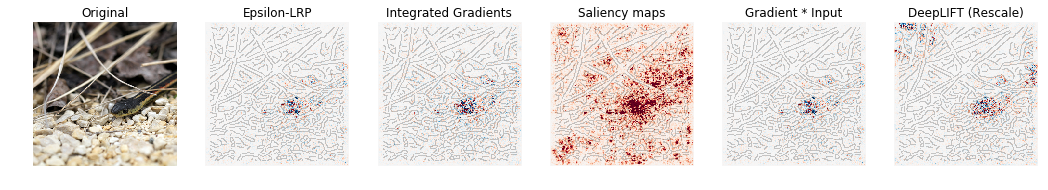

In [14]:
# Plot attributions
from utils import plot, plt
%matplotlib inline

n_cols = int(len(attributions)) + 1
n_rows = batch_shape[0] 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, xi in enumerate(xs):
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    axes[i].imshow(xi)
    axes[i].set_title('Original')
    axes[i].axis('off')
    #plot(xs, axis=axes[i]).set_title('Original')
    for j, a in enumerate(attributions):
        plot(attributions[a][i], xi = xi, axis=axes[j+1], dilation=.5, percentile=97, alpha=.2).set_title(a)